In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

# Prepare aging data to work with
- We divide the data by the starting value, so the values are R/R_0 relative degredation to initial value
- Then we invert to get to conductances 
- Now we normalize the livetime to $(t_0, t_1) = [0,1]$ from 0 , 37  as t0 and t1

In [2]:
data = pd.read_csv('group2.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data['days'] = data.index
data.days = data.days.diff().dt.days
data.days = data.days.fillna(0).cumsum()
#data.index = pd.to_datetime(data.index)
data.index = data.days
data = data.drop('days', axis=1)
data

,Res_0,Res_1,Res_2,Res_3,Res_4,Res_5
days,,,,,,
0.0,15681.818182,10000.000000,11785.714286,14166.666667,17500.000000,14166.666667
1.0,16730.769231,11785.714286,11785.714286,15681.818182,18776.595745,15681.818182
2.0,17500.000000,12425.373134,12884.615385,17500.000000,19722.222222,16730.769231
3.0,19722.222222,13629.032258,14166.666667,19722.222222,22500.000000,17500.000000
6.0,21309.523810,14166.666667,15681.818182,22500.000000,23815.789474,18776.595745
9.0,22500.000000,15681.818182,15681.818182,22500.000000,26071.428571,19722.222222
16.0,26071.428571,16547.619048,17500.000000,22500.000000,28269.230769,21029.411765
23.0,28750.000000,17500.000000,18333.333333,26071.428571,28750.000000,21309.523810
37.0,30833.333333,22500.000000,22500.000000,33214.285714,30833.333333,22500.000000


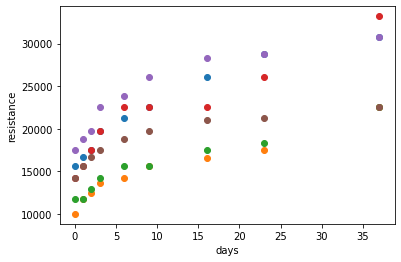

In [3]:
for i, c in enumerate(data.columns):
    x, y = data.index, data[c]
    plt.scatter(data.index, data[c], cmap=np.random.randint(10))
plt.ylabel('resistance');
plt.xlabel('days');

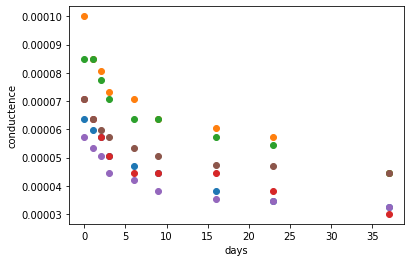

In [4]:
for i, c in enumerate(data.columns):
    x, y = data.index, data[c]
    plt.scatter(data.index, 1/data[c], cmap=np.random.randint(10))
plt.ylabel('conductence');
plt.xlabel('days');

In [5]:
data = data/data.min()  # ratio to initial value
data = 1/data
data.index = data.index/data.index.max()
data.columns = ['Cond_{}'.format(i) for i in range(data.shape[1])]
data

,Cond_0,Cond_1,Cond_2,Cond_3,Cond_4,Cond_5
days,,,,,,
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.027027,0.937304,0.848485,1.000000,0.903382,0.932011,0.903382
0.054054,0.896104,0.804805,0.914712,0.809524,0.887324,0.846743
0.081081,0.795134,0.733728,0.831933,0.718310,0.777778,0.809524
0.162162,0.735907,0.705882,0.751553,0.629630,0.734807,0.754485
0.243243,0.696970,0.637681,0.751553,0.629630,0.671233,0.718310
0.432432,0.601494,0.604317,0.673469,0.629630,0.619048,0.673660
0.621622,0.545455,0.571429,0.642857,0.543379,0.608696,0.664804
1.000000,0.508600,0.444444,0.523810,0.426523,0.567568,0.629630


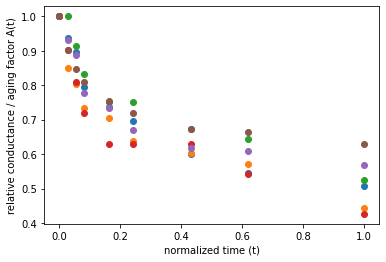

In [6]:
for i, c in enumerate(data.columns):
    plt.scatter(data.index, data[c], cmap=np.random.randint(10))
plt.ylabel('relative conductance / aging factor A(t)');
plt.xlabel('normalized time (t)');

## Aging Model: $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$

# Fit Model

In [7]:
from scipy.optimize import curve_fit
from scipy.special import comb


def get_piecewise_linear(x, *params):
    ''' 
    approximate the aging by two-segment linear function
    '''

    m0, m1, b1 = params
    b0 = 1

    def mod(z): return max(z*m0 + b0, z*m1 + b1)

    return np.array([mod(xi) for xi in x])


def get_exponential_function(x, *params):
    '''
    approximate the aging by exponential function
    '''
    a, b = params
    return a * np.exp(b * x) + 1 - a

Text(0.5, 1.0, 'double linear model')

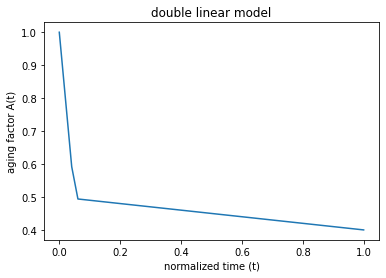

In [8]:
p0 = np.array([-10, -.1, .5])
vals = np.linspace(0, 1)
plt.plot(vals, get_piecewise_linear(vals, *p0))
plt.ylabel('aging factor A(t)')
plt.xlabel('normalized time (t)')
plt.title('double linear model')

Text(0.5, 1.0, 'exponential aging model')

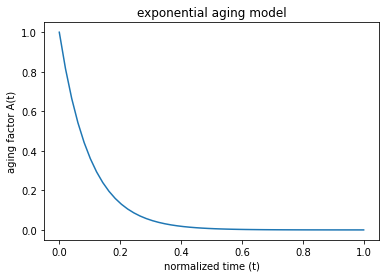

In [9]:
params = [1, -10]
vals = np.linspace(0, 1)
plt.plot(vals, get_exponential_function(vals, *params))
plt.ylabel('aging factor A(t)')
plt.xlabel('normalized time (t)')
plt.title('exponential aging model')

## Approximation

Text(0, 0.5, 'aging factor A(t)')

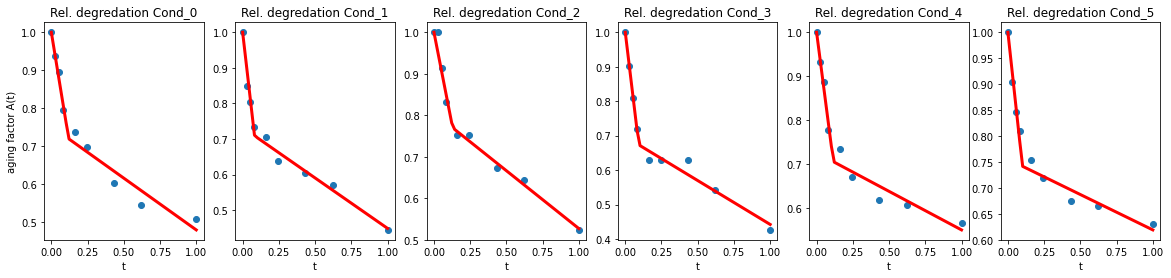

In [10]:
fig, ax = plt.subplots(ncols=len(data.columns), figsize=(20, 4))

# bounds and starting value for fitting
# np.array([-2, -1, -3])  # <--------------------- the more numbers you put there the more params you have !
p0 = np.array([-10, -.1, .5])
bnds = [[-np.inf, -np.inf, -np.inf], [0, 0, 1]]
#bnds = list(zip(*[(-np.inf, 0)]*len(p0)))

param_sets_linear = []
for i, c in enumerate(data.columns):

    x, y = data.index, data[c]
    ax[i].scatter(data.index, data[c])

    re = curve_fit(get_piecewise_linear, xdata=x, ydata=y,
                   p0=p0, maxfev=2000, bounds=bnds)[0]
    ax[i].plot(vals, get_piecewise_linear(vals, *re), c='red', lw=3)
    ax[i].set_title('Rel. degredation '+c)
    ax[i].set_xlabel('t')
    p0 = re
    param_sets_linear.append(re)
ax[0].set_ylabel('aging factor A(t)')

Text(0, 0.5, 'aging factor A(t)')

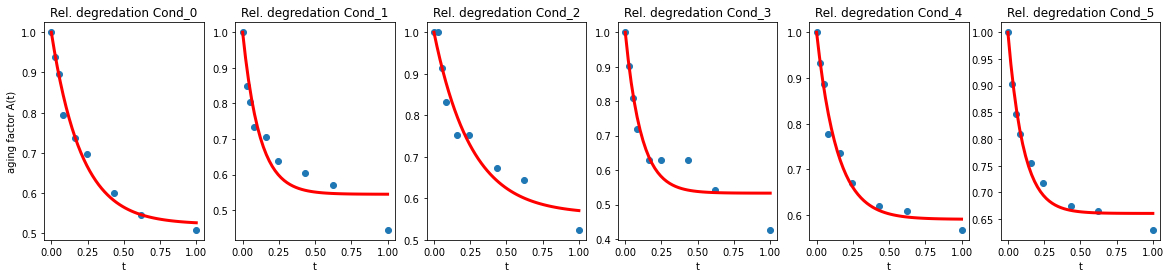

In [11]:
fig, ax = plt.subplots(ncols=len(data.columns), figsize=(20, 4))

# bounds and starting value for fitting
p0 = [1, -10]
bnds = [[-np.inf, -np.inf], [np.inf, 0]]

param_sets_exp = []
for i, c in enumerate(data.columns):

    x, y = data.index, data[c]
    ax[i].scatter(data.index, data[c])

    re = curve_fit(get_exponential_function, xdata=x, ydata=y,
                   p0=p0, maxfev=2000, bounds=bnds)[0]
    ax[i].plot(vals, get_exponential_function(vals, *re), c='red', lw=3)
    ax[i].set_title('Rel. degredation '+c)
    ax[i].set_xlabel('t')
    p0 = re
    param_sets_exp.append(re)
ax[0].set_ylabel('aging factor A(t)')

# Model the parameter distribution
- Model the param sets with some distribution model, very simple independent sampling for now

In [12]:
param_data_linear_approx = pd.DataFrame(
    param_sets_linear, columns=['m0', 'm1', 'b1'])
params_scales = param_data_linear_approx.std()
params_scales[param_data_linear_approx.max(0) < 0.001] = 0.
param_data_linear_approx

,m0,m1,b1
0,-2.339153,-0.272843,0.751894
1,-3.543337,-0.283429,0.732167
2,-1.783340,-0.278735,0.805756
3,-3.495552,-0.254715,0.697051
4,-2.537163,-0.175123,0.726412
5,-2.575624,-0.136441,0.755292


In [13]:
param_data_exp_approx = pd.DataFrame(param_sets_exp, columns=['a', 'b'])
params_scales = param_data_exp_approx.std()
params_scales[param_data_exp_approx.max(0) < 0.001] = 0.
param_data_exp_approx

,a,b
0,0.477429,-4.835317
1,0.455294,-8.607224
2,0.438617,-3.886392
3,0.466833,-9.147731
4,0.409194,-7.068652
5,0.339458,-9.422527


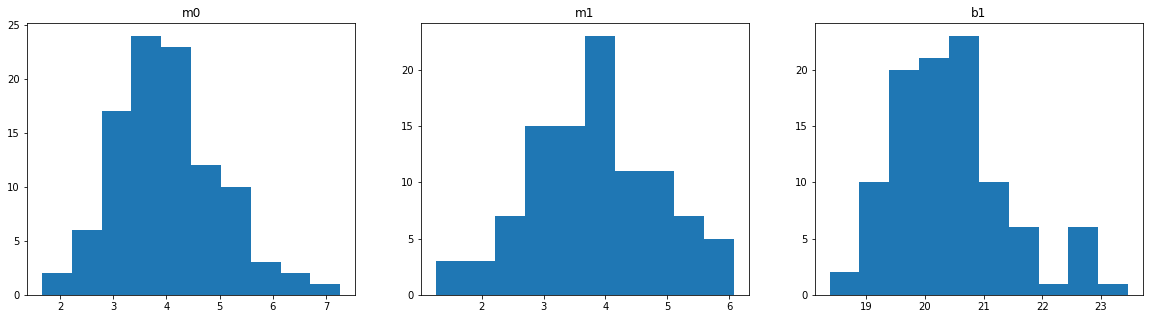

In [14]:
from scipy.stats import norm, chi2, lognorm

# maybe tranform them into a certain range and then invert them ?

# some positive distribution to model the parameters
# chi2 # lognorm #   <--------------------------------------------- can try different ones here
base_dist = lognorm
dists_linear = {c: base_dist(*base_dist.fit(param_data_linear_approx[c].abs(
)/param_data_linear_approx[c].std())) for c in param_data_linear_approx.columns}

fig, ax = plt.subplots(1, param_data_linear_approx.shape[1], figsize=(20, 5))
for i, c in enumerate(param_data_linear_approx.columns):
    ax[i].hist(dists_linear[c].rvs(100))
    ax[i].set_title(c)

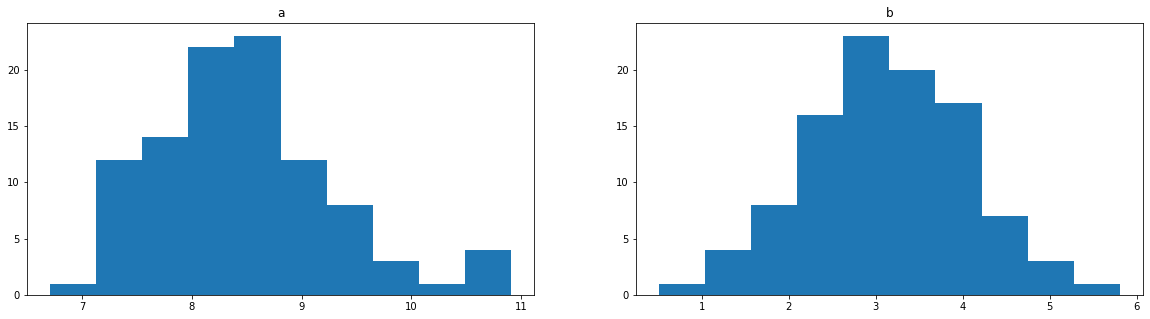

In [15]:
base_dist = lognorm
dists_exp = {c: base_dist(*base_dist.fit(param_data_exp_approx[c].abs(
)/param_data_exp_approx[c].std())) for c in param_data_exp_approx.columns}

fig, ax = plt.subplots(1, param_data_exp_approx.shape[1], figsize=(20, 5))
for i, c in enumerate(param_data_exp_approx.columns):
    ax[i].hist(dists_exp[c].rvs(100))
    ax[i].set_title(c)

# Draw samples 

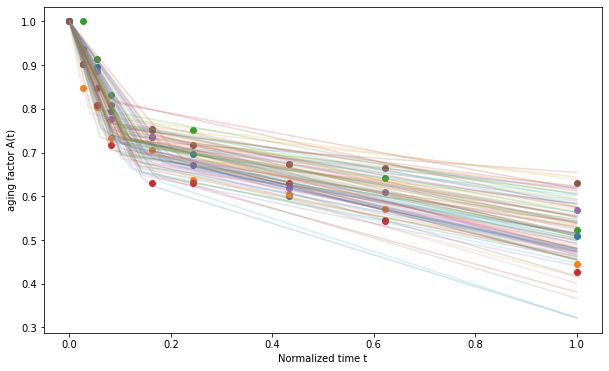

In [16]:
plt.figure(figsize=(10, 6))
plt.xlabel('Normalized time t')
plt.ylabel('aging factor A(t)')


def get_param_sample():
    ''' samples from the param distributions '''
    return np.array([dists_linear[c].rvs(1)*param_data_linear_approx[c].std() for c in param_data_linear_approx.columns]).ravel()


def transform_sample(x):
    ''' negates first entries '''
    return np.r_[-x[:-1], x[-1]]


np.random.seed(2)
for i in range(100):
    plt.plot(vals, get_piecewise_linear(
        vals, *transform_sample(get_param_sample())), alpha=.2, )

for i, c in enumerate(data.columns):
    x, y = data.index, data[c]
    plt.scatter(data.index, data[c])

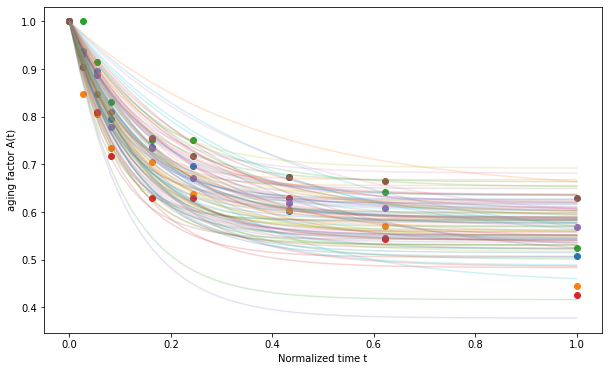

In [17]:
plt.figure(figsize=(10, 6))
plt.xlabel('Normalized time t')
plt.ylabel('aging factor A(t)')


def get_param_sample():
    ''' samples from the param distributions '''
    return np.array([dists_exp[c].rvs(1)*param_data_exp_approx[c].std() for c in param_data_exp_approx.columns]).ravel()


def transform_sample(x):
    ''' negates first entries '''
    return np.r_[x[0], -x[1]]


np.random.seed(2)
for i in range(100):
    plt.plot(vals, get_exponential_function(
        vals, *transform_sample(get_param_sample())), alpha=.2, )

for i, c in enumerate(data.columns):
    x, y = data.index, data[c]
    plt.scatter(data.index, data[c])

# Aging model generator

In [18]:
import aging_model_generator as amg
import importlib
importlib.reload(amg)

linear_aging_model_generator = amg.Linear_aging_model_sampler(
    dists_linear, param_data_linear_approx)
exp_aging_model_generator = amg.Exp_aging_model_sampler(
    dists_exp, param_data_exp_approx)

In [19]:
test_linear = linear_aging_model_generator
test_exp = exp_aging_model_generator

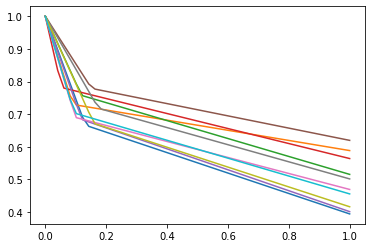

In [20]:
tut_linear = test_linear.get_models(10)
vals = np.linspace(0, 1)
for i in range(10):
    plt.plot(vals, tut_linear[i](vals))

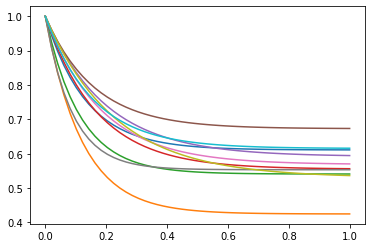

In [21]:
tut_exp = test_exp.get_models(10)
for i in range(10):
    plt.plot(vals, tut_exp[i](vals))

In [22]:
import pickle
with open('linear_aging_model.p', 'wb') as f:
    pickle.dump(linear_aging_model_generator, f)

In [23]:
with open('exp_aging_model.p', 'wb') as f:
    pickle.dump(exp_aging_model_generator, f)

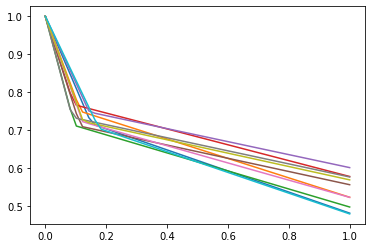

In [24]:
with open('linear_aging_model.p', 'rb') as f:
    try_linear = pickle.load(f)
linear_temp = try_linear.get_models(10)
for i in range(10):
    plt.plot(vals, linear_temp[i](vals))

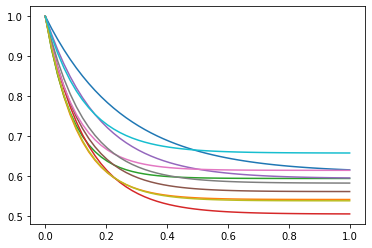

In [25]:
with open('exp_aging_model.p', 'rb') as f:
    try_exp = pickle.load(f)
exp_temp = try_exp.get_models(10)
for i in range(10):
    plt.plot(vals, exp_temp[i](vals))